In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient

In [2]:
# Connexion à MongoDB et chargement des données
client = MongoClient("localhost", 27017)
db = client.IF29
collec = db.user_db_norm
data_db = pd.DataFrame(list(collec.find()))
data = data_db.sample(frac=0.01)

In [3]:
features = ['verified', 'protected', 'friend_nb',
        'listed_nb', 'follower_nb', 'favorites_nb', 'len_description',
        'hash_avg', 'mention_avg', 'url_avg', 'symbols_avg', 'tweet_nb',
        'tweet_user_count', 'user_lifetime', 'tweet_frequency',
        'friend_frequency', 'aggressivity', 'visibility', 'ff_ratio'
]
X = data[features]

In [4]:
pca = PCA()
pca_res = pca.fit_transform(X)

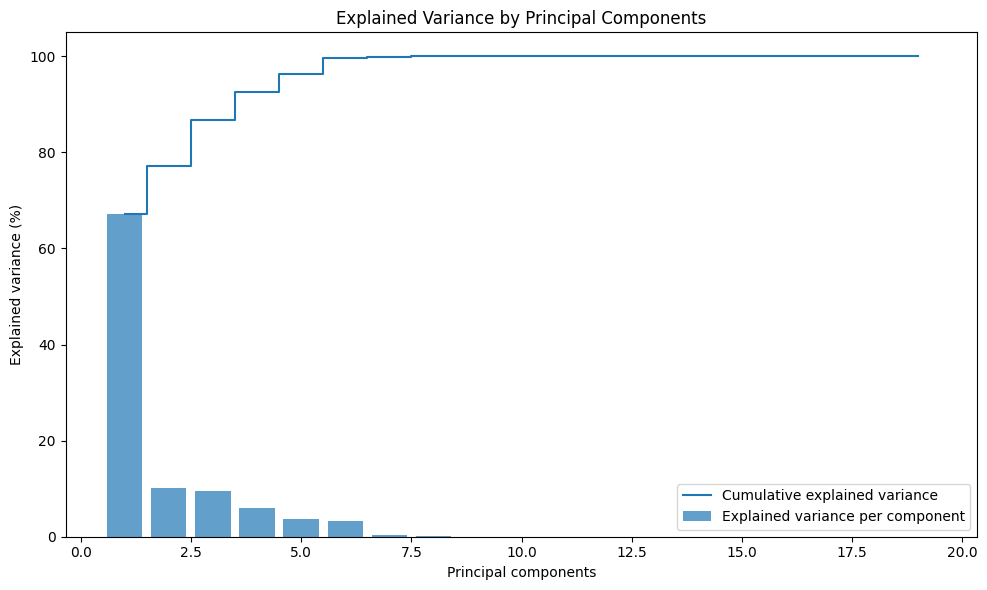

In [5]:

# Calculer les pourcentages d'information expliquée
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio_cumulative = np.cumsum(explained_variance_ratio)

# Plot des variances expliquées
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio * 100, alpha=0.7, align='center', label='Explained variance per component')
plt.step(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio_cumulative * 100, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance (%)')
plt.xlabel('Principal components')
plt.title('Explained Variance by Principal Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [6]:
# Récupérer les composantes principales
components = pca.components_

# Calculer la contribution absolue de chaque variable pour les trois premiers axes
contributions = np.abs(components[:3])

# Créer un DataFrame pour afficher les contributions
contribution_df = pd.DataFrame(contributions.T, index=features, columns=['PC1', 'PC2', 'PC3'])

# Calculer la somme des contributions pour chaque variable sur les trois premiers axes
contribution_df['Total'] = contribution_df.sum(axis=1)

# Trier les variables par leur contribution totale
contribution_df = contribution_df.sort_values(by='Total', ascending=False)

# Afficher les contributions
print(contribution_df)

                           PC1           PC2           PC3         Total
verified          4.482015e-02  7.628343e-01  6.408215e-01  1.448476e+00
url_avg           1.969691e-02  5.179391e-01  5.961942e-01  1.133830e+00
len_description   9.974255e-01  5.103285e-02  1.359954e-02  1.062058e+00
hash_avg          6.201880e-03  2.540256e-01  3.211498e-01  5.813773e-01
visibility        7.572392e-04  2.194991e-01  2.922402e-01  5.124966e-01
mention_avg       2.278629e-02  1.618123e-01  2.123263e-01  3.969249e-01
user_lifetime     4.637941e-02  9.103812e-02  7.324841e-03  1.447424e-01
favorites_nb      4.097114e-03  1.808313e-03  4.180941e-03  1.008637e-02
follower_nb       2.837185e-04  4.063966e-03  3.321727e-03  7.669412e-03
aggressivity      2.786426e-03  1.486881e-03  1.598353e-03  5.871661e-03
listed_nb         4.439031e-04  2.697111e-03  2.021904e-03  5.162918e-03
tweet_user_count  1.939888e-03  2.629094e-03  3.837020e-04  4.952684e-03
tweet_frequency   2.475438e-03  8.519556e-04  1.224

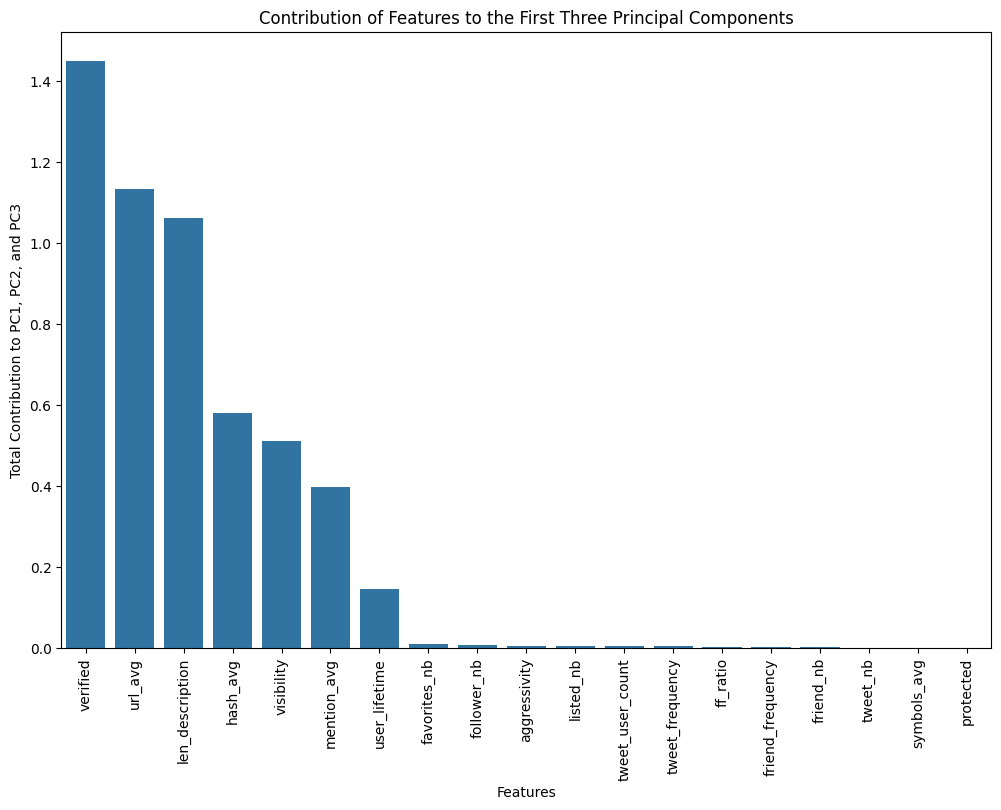

In [7]:
# Visualiser les contributions des variables pour les trois premiers axes
plt.figure(figsize=(12, 8))
sns.barplot(x=contribution_df.index, y=contribution_df['Total'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Total Contribution to PC1, PC2, and PC3')
plt.title('Contribution of Features to the First Three Principal Components')
plt.show()

In [8]:
# Variance expliquée cumulative
explained_variance_ratio_cumulative = np.cumsum(pca.explained_variance_ratio_)

# Choix automatique du nombre de composantes
threshold = 0.80  # seuil de variance expliquée cumulative à atteindre
num_components = np.argmax(explained_variance_ratio_cumulative >= threshold) + 1

print(f'Number of components to retain {threshold*100}% variance: {num_components}')

# Réduction des dimensions de pca_res
pca_res_reduced = pca.transform(X)[:, :num_components]

Number of components to retain 80.0% variance: 3


In [9]:
cah = linkage(pca_res_reduced, method="ward")
print(cah)

[[9.90000000e+03 1.75800000e+04 0.00000000e+00 2.00000000e+00]
 [7.84600000e+03 1.13580000e+04 0.00000000e+00 2.00000000e+00]
 [3.21300000e+03 1.44060000e+04 0.00000000e+00 2.00000000e+00]
 ...
 [3.68610000e+04 3.68630000e+04 1.59816843e+01 1.29300000e+04]
 [3.68530000e+04 3.68620000e+04 1.77849399e+01 5.50400000e+03]
 [3.68640000e+04 3.68650000e+04 4.01719746e+01 1.84340000e+04]]


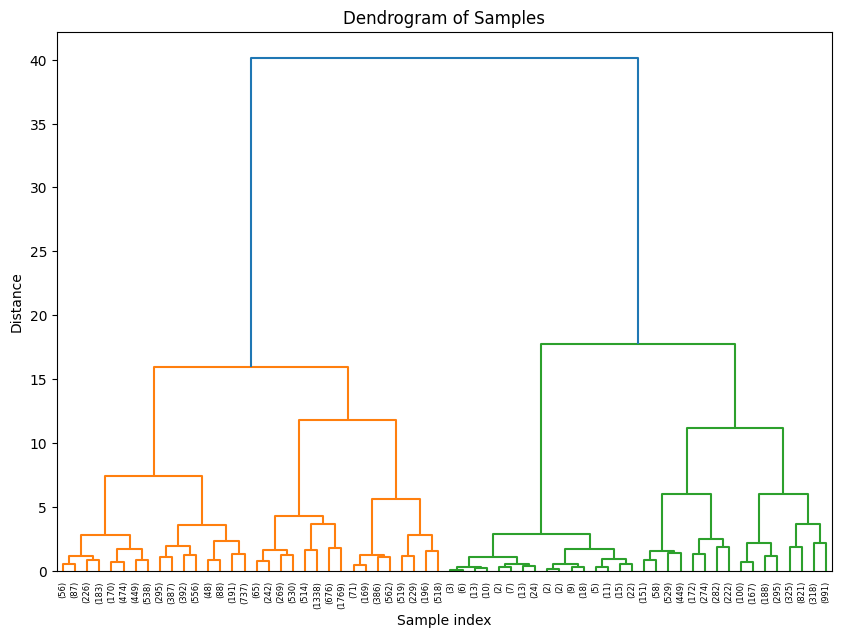

In [10]:
# Dendrogramme des échantillons
plt.figure(figsize=(10, 7))
dendrogram(cah, truncate_mode="level", p=5)
plt.title('Dendrogram of Samples')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In [11]:
from sklearn.metrics import silhouette_score
# Fonction pour trouver le meilleur seuil max_d
def optimal_dendrogram_cut(cah, pca_res, min_clusters=2, max_clusters=10):
    best_silhouette_score = -1
    best_num_clusters = 0
    best_clusters = None

    for num_clusters in range(min_clusters, max_clusters + 1):
        # Utiliser fcluster pour couper le dendrogramme à num_clusters
        clusters = fcluster(cah, num_clusters, criterion='maxclust')
        
        # Calculer le score de silhouette pour les clusters
        silhouette_avg = silhouette_score(pca_res, clusters)
        
        # Comparer et garder le meilleur score de silhouette
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_num_clusters = num_clusters
            best_clusters = clusters
            
    return best_num_clusters, best_clusters, best_silhouette_score

In [12]:
# Trouver le meilleur nombre de clusters
best_num_clusters, best_clusters_hierarchical, best_silhouette_score = optimal_dendrogram_cut(cah, pca_res_reduced)

print(f'Best number of clusters: {best_num_clusters}')
print(f'Best silhouette score: {best_silhouette_score}')

Best number of clusters: 3
Best silhouette score: 0.5616939830608031


In [13]:
# Appliquer k-means avec le nombre de clusters déterminé
kmeans = KMeans(n_clusters=best_num_clusters)
clusters_kmeans = kmeans.fit_predict(pca_res_reduced)

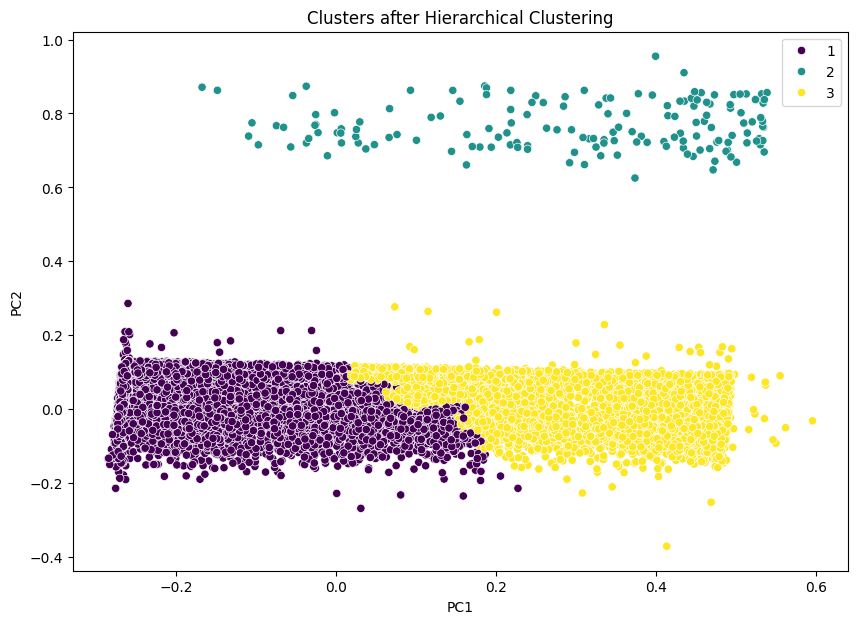

In [14]:
# Visualisation des clusters hiérarchiques
plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_res[:, 0], y=pca_res[:, 1], hue=best_clusters_hierarchical, palette="viridis")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title('Clusters after Hierarchical Clustering')
plt.show()

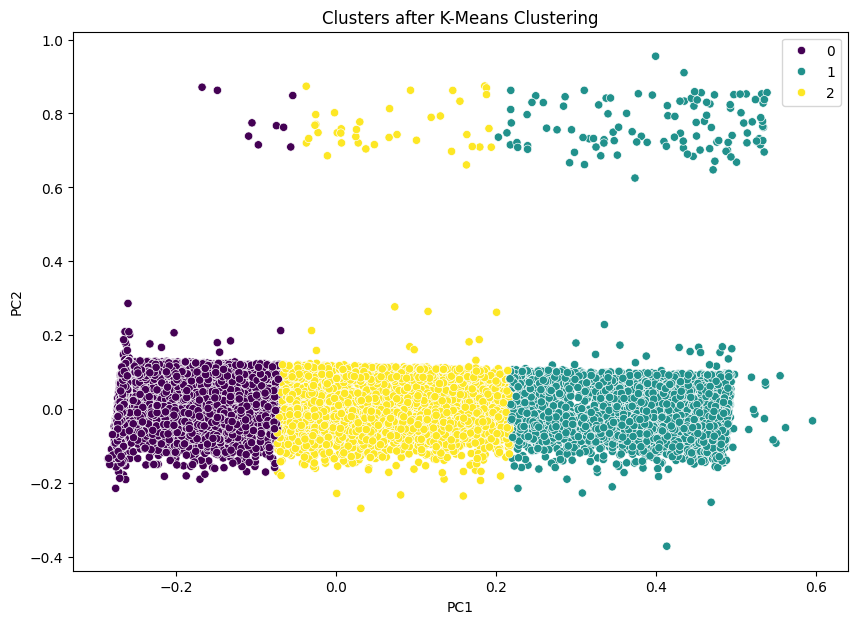

In [15]:
# Visualisation des clusters k-means
plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_res[:, 0], y=pca_res[:, 1], hue=clusters_kmeans, palette="viridis")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title('Clusters after K-Means Clustering')
plt.show()

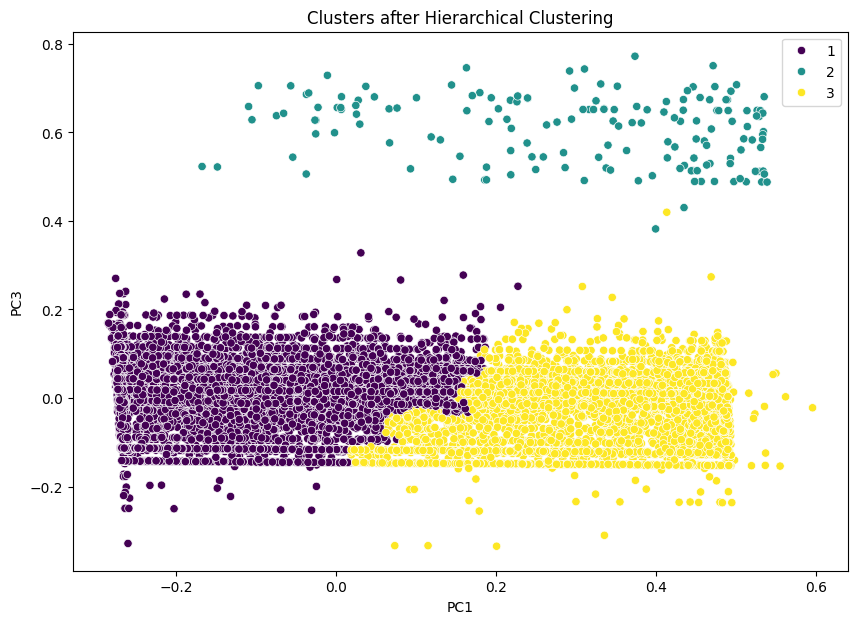

In [16]:
# Visualisation des clusters hiérarchiques
plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_res[:, 0], y=pca_res[:, 2], hue=best_clusters_hierarchical, palette="viridis")
plt.xlabel("PC1")
plt.ylabel("PC3")
plt.title('Clusters after Hierarchical Clustering')
plt.show()

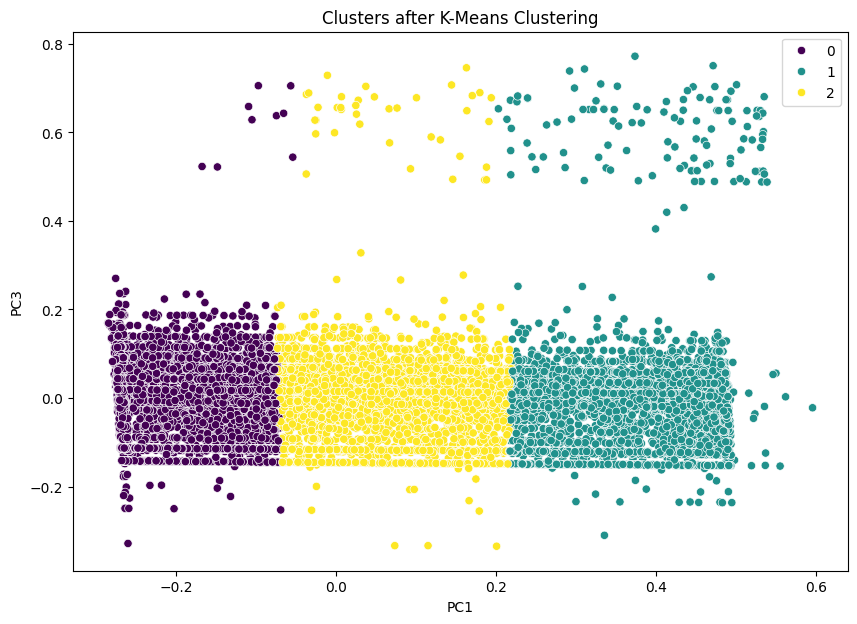

In [17]:
# Visualisation des clusters k-means
plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_res[:, 0], y=pca_res[:, 2], hue=clusters_kmeans, palette="viridis")
plt.xlabel("PC1")
plt.ylabel("PC3")
plt.title('Clusters after K-Means Clustering')
plt.show()

In [18]:
# Ajouter les clusters hiérarchiques et k-means aux données
data['cluster_hierarchical'] = best_clusters_hierarchical
data['cluster_kmeans'] = clusters_kmeans

In [19]:
# Calculer les statistiques descriptives pour chaque cluster hiérarchique
cluster_hierarchical_describe = data.groupby('cluster_hierarchical').describe()
print("Statistiques descriptives pour les clusters hiérarchiques :")
print(cluster_hierarchical_describe)

Statistiques descriptives pour les clusters hiérarchiques :
                          _id                                         \
                        count          mean           std        min   
cluster_hierarchical                                                   
1                     12930.0  2.513734e+17  4.018217e+17   803156.0   
2                       162.0  2.347015e+16  1.324821e+17  2566991.0   
3                      5342.0  1.826601e+17  3.569443e+17  1014821.0   

                                                                              \
                               25%           50%           75%           max   
cluster_hierarchical                                                           
1                     3.754864e+08  2.165770e+09  7.479276e+17  1.008381e+18   
2                     4.224202e+07  1.891691e+08  5.179443e+08  8.890565e+17   
3                     1.930607e+08  7.087230e+08  3.386892e+09  1.008377e+18   

                     verif

In [20]:

# Calculer les statistiques descriptives pour chaque cluster k-means
cluster_kmeans_describe = data.groupby('cluster_kmeans').describe()
print("Statistiques descriptives pour les clusters k-means :")
print(cluster_kmeans_describe)

Statistiques descriptives pour les clusters k-means :
                   _id                                                       \
                 count          mean           std        min           25%   
cluster_kmeans                                                                
0               9174.0  2.679963e+17  4.102886e+17  6798652.0  4.228699e+08   
1               4165.0  1.751914e+17  3.514686e+17  1014821.0  1.700896e+08   
2               5095.0  2.044280e+17  3.728125e+17   803156.0  2.651035e+08   

                                                         verified            \
                         50%           75%           max    count      mean   
cluster_kmeans                                                                
0               2.333638e+09  7.674589e+17  1.008381e+18   9174.0  0.000981   
1               5.867120e+08  3.309570e+09  1.008377e+18   4165.0  0.027611   
2               1.041872e+09  4.431787e+09  1.008245e+18   5095.0  0.007458 

In [23]:
# Enregistrer le DataFrame en fichier CSV
cluster_kmeans_describe.to_csv('HCPC_describe.csv')
cluster_hierarchical_describe.to_csv('CAH_describe.csv')